# Gaussian Process in 1D (GP lab part 1)

**Machine Learning, University of Zaragoza, Ruben Martinez-Cantin**

This document shows how to use Gaussian processes for regression, and how important are the kernel function and hyperparameters.

You can use this code to play with different configurations using a popular GP library (GPy).

(based on GPSS labs)

# How to submit the results

Make a copy of this file in your Drive. Then you can use textboxes to write directly your report. Download as .ipynb and submit that file in Moodle.

In this part of the lab, we are going to use the [GPy library](http://sheffieldml.github.io/GPy/), which is not installed by default in colab, but we can get it from pip.

In [2]:
!pip install GPy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 12.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [3]:
#@title import libraries
import numpy as np
import scipy as sp
import GPy

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 6)
rcParams['legend.fontsize'] = 16
rcParams['axes.labelsize'] = 16

We will use the [weight dataset](https://drive.google.com/file/d/1YYyQG-xuS1OV5Ww1ytZLzhe3YdvE_NKG/view?usp=sharing) from [Philipp Hennig](https://uni-tuebingen.de/en/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/informatik/lehrstuehle/methoden-des-maschinellen-lernens/personen/philipp-hennig/)

In [4]:
!wget https://raw.githubusercontent.com/rmcantin/gp_lab/main/datasets/weightdata_clean.mat

--2024-10-23 19:52:49--  https://raw.githubusercontent.com/rmcantin/gp_lab/main/datasets/weightdata_clean.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4877 (4.8K) [application/octet-stream]
Saving to: ‘weightdata_clean.mat’

weightdata_clean.ma 100%[===================>]   4.76K  --.-KB/s    in 0s      

2024-10-23 19:52:50 (50.4 MB/s) - ‘weightdata_clean.mat’ saved [4877/4877]



Size inputs: (842, 1) Size outputs (842, 1)


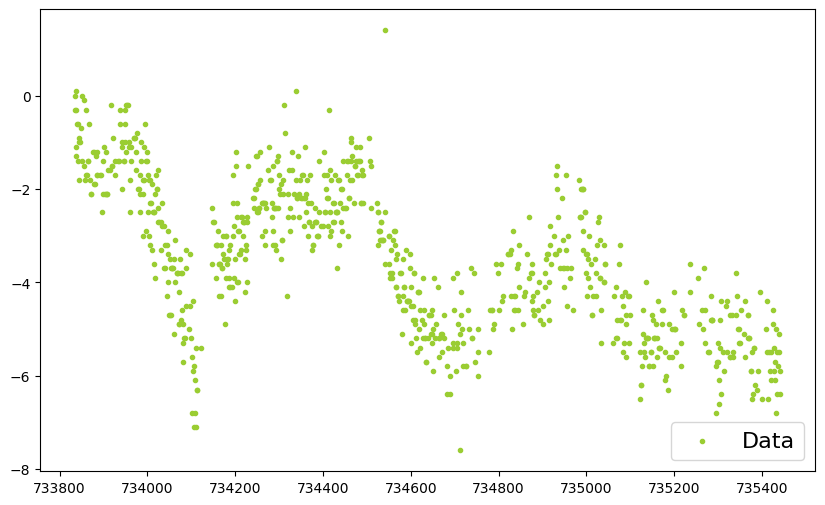

In [5]:
#@title Load data
# You can also use the weight dataset by uncommenting these lines
data=sp.io.loadmat('weightdata_clean.mat')
X = np.atleast_2d(data['dat'][:,0]).T
Y = np.atleast_2d(data['dat'][:,1]).T

# This can be use to subsample the dataset
subsample = 1
X = X[::subsample,:]
Y = Y[::subsample,:]

# Make sure the data is there
print("Size inputs:", X.shape, "Size outputs",Y.shape)
plt.scatter(X, Y, color='yellowgreen', marker='.',label='Data')
plt.legend(loc='lower right')

Here we define a quick plotting utility function for our GP fits. There are a number of plotting options available in GPy, but we will use the below method, which plots the mean and 95% confidence fit of a GP for a given input $\mathbf{X}^*$. Optionally, we will allow it to plot the initial training points.

In [6]:
def plot_gp(X, m, C, training_points=None, ax=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    if ax is None:
        ax = plt.gca()  # Usa el eje global si no se proporciona uno

    # Plot 95% confidence interval
    ax.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)),
                     m[:,0] + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.5,)

    # Plot GP mean and initial training points
    ax.plot(X, m, "-")

    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        ax.plot(X_, Y_, "kx", mew=2)

    ax.legend()

    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")


# Using GPy



## Covariance functions, aka kernels

We will define a covariance function, from hereon referred to as a kernel, using `GPy`. The most commonly used kernel in machine learning is the Gaussian-form radial basis function (RBF) kernel. It is also commonly referred to as the exponentiated quadratic or squared exponential kernel &ndash; all are equivalent.

The definition of the (1-dimensional) RBF kernel has a Gaussian-form, defined as:

$$
    \kappa_\mathrm{rbf}(x,x') = \sigma^2\exp\left(-\frac{(x-x')^2}{2\mathscr{l}^2}\right)
$$

It has two parameters, described as the variance, $\sigma^2$ and the lengthscale $\mathscr{l}$.

In GPy, we define our kernels using the input dimension as the first argument, in the simplest case `input_dim=1` for 1-dimensional regression. We can also explicitly define the parameters, but for now we will use the default values:

In [ ]:
# Create a 1-D RBF kernel with default parameters
# If you type GPy.kern. and wait, autocomplete will show you all available kernels
k = GPy.kern.RBF(input_dim = 1)

# Preview the kernel's parameters
display(k)

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1.0,+ve,


## Types of covariance function

There are many different covariance functions already implemented in `GPy`. Aside from the `RBF` kernel, there are others such as the following:
- `Exponential`
- `Matern32`
- `Matern52`
- `Brownian`
- `Bias`
- `Linear`
- `StdPeriodic`
- `Cosine`
- `PeriodicMatern32`,

Note: when defining these, all are preceded by `GPy.kern.` The following are some examples of the [Matérn 5/2](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function) and Cosine kernels, compared with the RBF kernel:

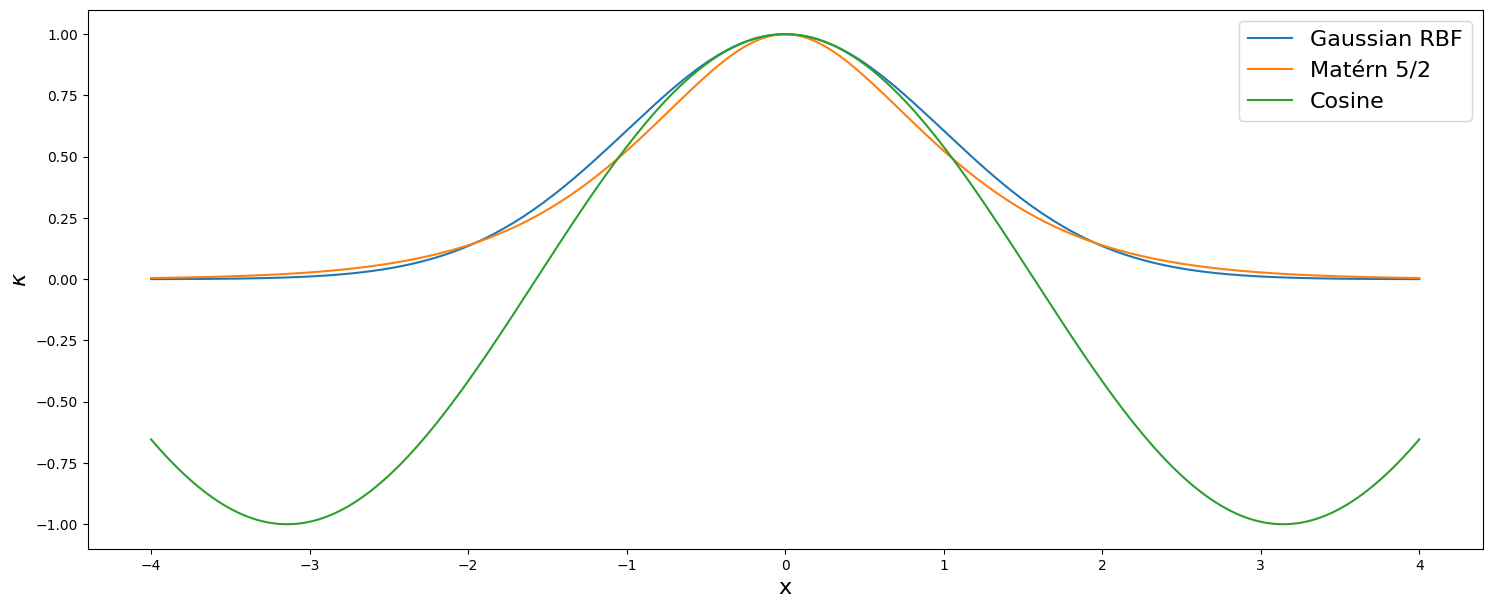

In [ ]:
# Our sample space : 100 samples in the interval [-4,4]
X_mod = np.linspace(-4.,4.,250)[:, None]

# RBF kernel
k_R = GPy.kern.RBF(1)
C_R = k_R.K(X_mod, np.array([[0.]]))

# Matern 5/2
k_M = GPy.kern.Matern52(1)
C_M = k_M.K(X_mod, np.array([[0.]]))

# Cosine
k_C = GPy.kern.Cosine(1)
C_C = k_C.K(X_mod, np.array([[0.]]))

plt.figure(figsize=(18,7))
plt.plot(X_mod, C_R, X_mod, C_M, X_mod, C_C);
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.legend(labels=["Gaussian RBF", "Matérn 5/2", "Cosine"]);

## Combining kernels
We can easily combine kernels using GPy using the + and * operators, respectively denoting addition and product of kernels.

In [ ]:
# Create the first kernel: a 1-D RBF with lengthscale 2.0
k_R = GPy.kern.RBF(1, lengthscale=2., name="RBF")
# Create the second kernel: a 1-D Matern52 with variance 2.0 and lengthscale 4.0
k_M = GPy.kern.Matern52(1, variance=2., lengthscale=4., name="Matern52")

# Add the kernels together
k_sum = k_R + k_M
# Preview the properties of the composite kernel
k_sum

sum.,value,constraints,priors
RBF.variance,1.0,+ve,
RBF.lengthscale,2.0,+ve,
Matern52.variance,2.0,+ve,
Matern52.lengthscale,4.0,+ve,


## Sampling from a Gaussian Process

We can also sample from the kernel prior by creating a covariance matrix over a sample space and sampling from a zero-mean multivariate normal distribution with covariance $\mathbf{K}$ using the following function. You can use the previous kernels (including composite kernels) and generate samples of functions to see the behaviour of each kernel.

In [8]:
def plot_K_samples(kernel, kernel_name, N=2):
    X = np.linspace(0, 5., 250)[:, None]  # Sample space
    mu = np.zeros((250))  # Zero mean
    C = kernel.K(X)  # Covariance matrix for the kernel

    # Sample from the multivariate normal distribution
    Z = np.random.multivariate_normal(mu, C, N)

    for j in range(N):  # Loop through samples
        plt.plot(X, Z[j,:], label=f"Sample {j+1} ({kernel_name})")  # Adding a descriptive label

    plt.xlabel("X")
    plt.ylabel("Sample Value")
    plt.title(f"Samples from diferent kernels")

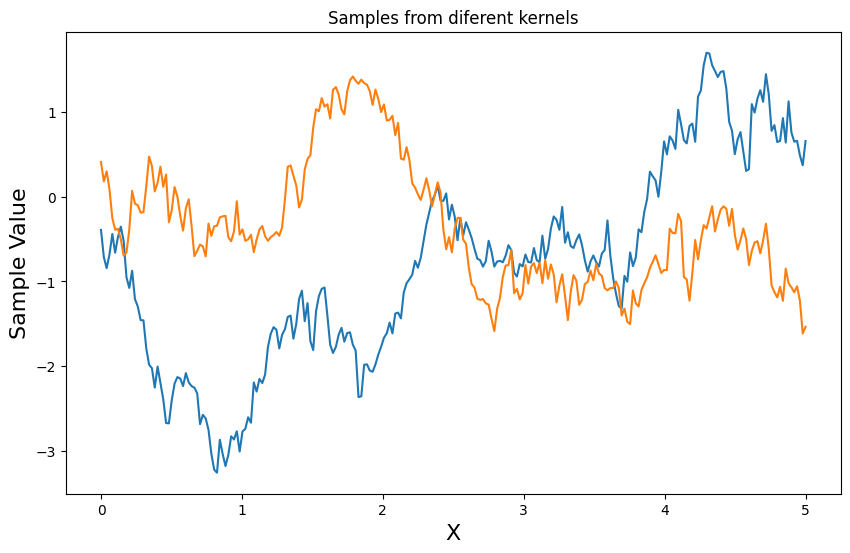

In [ ]:
k = GPy.kern.Exponential(1)
plot_K_samples(k, "Exponential")

## Gaussian process regression
In future exercises, we are going to implement our own Gaussian process. For the time being we can do Gaussian process regression using `GPy`, by creating a GP regression model with sample points $(\mathbf{X}, \mathbf{Y})$ and the Gaussian RBF kernel:

In [ ]:
k = GPy.kern.RBF(input_dim = 1)
m = GPy.models.GPRegression(X, Y, k)

# Preview the model's configuration
display(m)

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


We can use the prediction tools from GPy to obtain our model.

Note that, becuase there is no parametric model to plot, we estimate the prediction (predictive mean and variance) at a large set of points spread along the input space $X_{new}$ and that is what we plot.

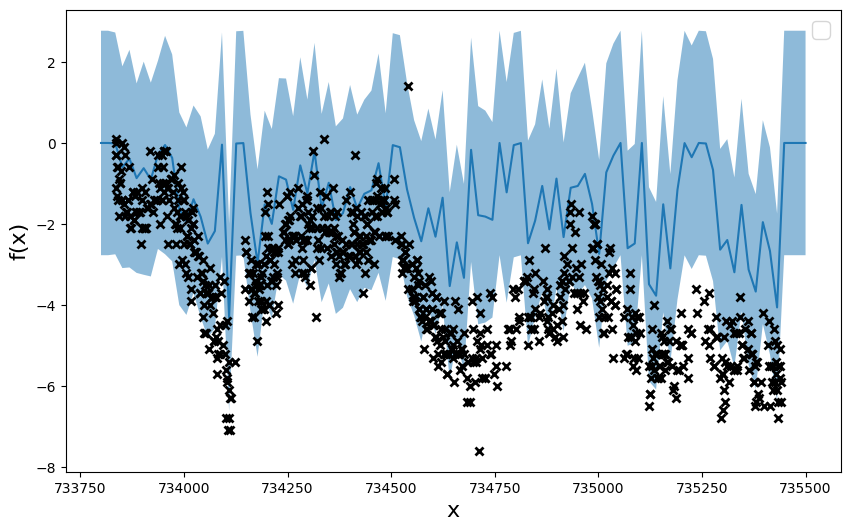

In [ ]:
# New test points to sample function from
Xnew = np.linspace(733800, 735500, 100)[:, None]

# Use GPy model to calculate the mean and covariance of the fit at Xnew
mean, Cov = m.predict(Xnew, full_cov=True)

# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))

We can see that the uncertainty can be very large because it combines both the model uncertainty and the observation uncertainty. If we use instead:

```
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)
```
we can obtain the prediction without the observation noise. We can see that the uncertainty is much smaller, because that would be only the uncertainty due to the model and not the data.

We can change the values of the hyperparameters by hand and see the performance of the regression model with different hyperparameters.

Here, we also use a built-in function for plotting in GPy. In this case, you can also replace `m.plot()` with `m.plot_noiseless()` if you want to ignore the data noise.

 /usr/local/lib/python3.10/dist-packages/GPy/core/gp.py:618: RuntimeWarning:covariance is not symmetric positive-semidefinite.


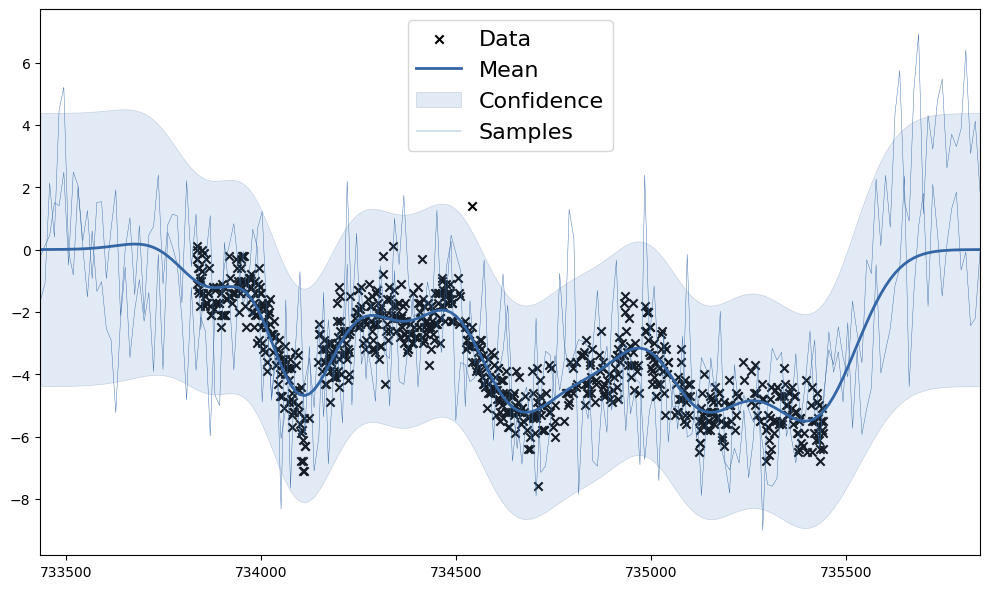

In [ ]:
# We can change the hyperparameters (kernel parameters and noise variance) by hand
# from the kernel object or from the model object. For example:

# CHOOSE YOUR OWN VALUES
k.variance = 2
m.rbf.lengthscale = 100
m.Gaussian_noise.variance = 3


fig = m.plot(
    samples = 2,        # number of samples of possible functions (0 for clean plot)
    plot_data = True,   # show data points
    legend = True       # show the plot legend
)

## Hyperparameter learning

Instead of selecting the hyperparameters by hand, we can learn them from the data. By default, GPy uses the log-likelihood of the evidence to estimate the optimal parameters.
$$
\theta^* = \arg\max_\theta \log p(\mathbf{y}|\mathbf{X})
$$

In practice, the optimization algorithm used is for minimization. Thus, we minimize the negative log-likelihood, which should give the same result.

$$
\theta^* = \arg\min_\theta - \log p(\mathbf{y}|\mathbf{X})
$$

You can see how the "Objective" (negative log-likelihood) value decreases compared to the hand selected parameters.

GP_regression.,value,constraints,priors
rbf.variance,9.524385055116202,+ve,
rbf.lengthscale,93.50693775155536,+ve,
Gaussian_noise.variance,0.47445934616756247,+ve,


{'dataplot': [<matplotlib.collections.PathCollection at 0x7c404b5692a0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7c404b569750>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7c404b569930>]}

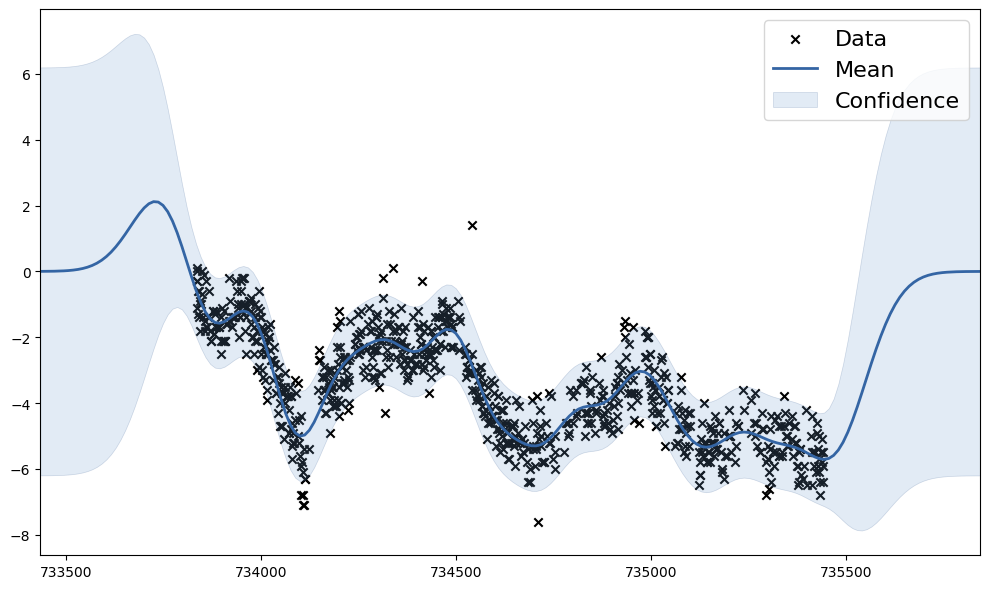

In [ ]:
m.optimize()

# Preview the model's configuration after learning
display(m)

m.plot()

We are using gradient methods to find the optimal hyperparameter. A common problem of gradient methods is that they can get stuck in local optima. To avoid that, we can run multiple optimizations from different initializations. With GPy we can do this with `optimize_restarts()`.

**WARNING**: The optimization is repeated for every restart. If we set `num_restarts` to a large number, we might need to wait a long time.

In [ ]:
m.optimize_restarts(num_restarts = 4)

Optimization restart 1/4, f = 941.1302202863758
Optimization restart 2/4, f = 941.1302202480474
Optimization restart 3/4, f = 941.1302202578597
Optimization restart 4/4, f = 941.1302202482007


# Your tasks
Revisit the previous sections trying diferent kernels, combinations of kernels, tuning the parameters "by hand" or throught ML (maximum likelihood, using `optimize`.

*   Which kernel provide the best fit? We have already found a metric in GPy for the fitness of the model.
*   Would it be possible to get a better fit than by ML? Hint: run the optimization multiple times with different initializations and compare the results.
*   Compare the noiseless (`predict_noiseless` or `plot_noiseless`) and "normal" predictions (`predict` or `plot`). Which one would you use to make decisions? Why?

Bayesian methods are much more interestings in applications with incomplete data. Try to repeat the process with just a selection of the whole dataset. For this, you can use the `subsample` variable in the data loading. We will use only 1 point for every `subsample` points.



## 0. Explore kernels

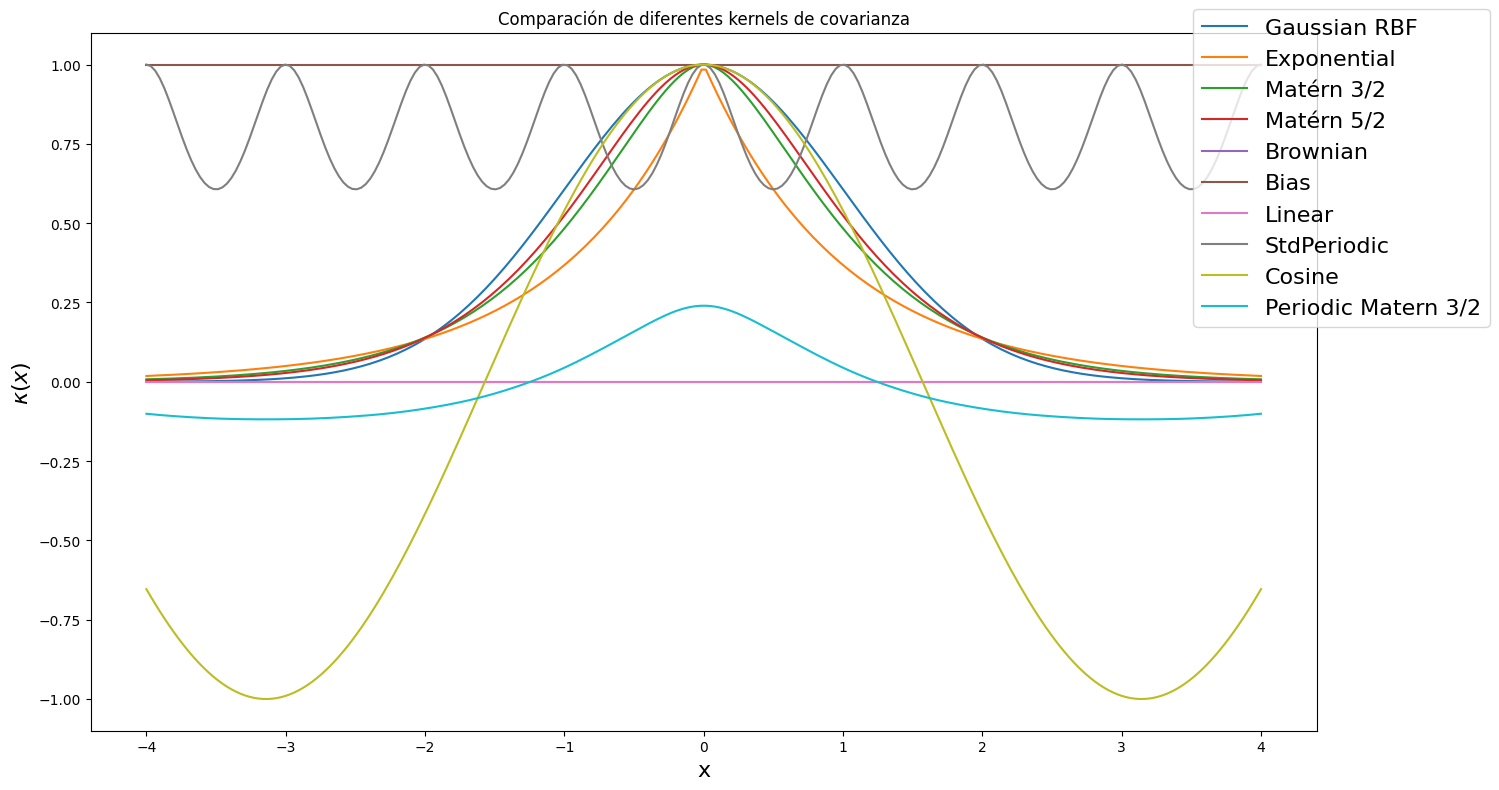

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

# Crear el espacio de muestras: 250 muestras en el intervalo [-4,4]
X = np.linspace(-4., 4., 250)[:, None]

# Inicializar cada kernel y calcular sus covarianzas
kernels = {
    "Gaussian RBF": GPy.kern.RBF(1),
    "Exponential": GPy.kern.Exponential(1),
    "Matérn 3/2": GPy.kern.Matern32(1),
    "Matérn 5/2": GPy.kern.Matern52(1),
    "Brownian": GPy.kern.Brownian(1),
    "Bias": GPy.kern.Bias(1),
    "Linear": GPy.kern.Linear(1),
    "StdPeriodic": GPy.kern.StdPeriodic(1),
    "Cosine": GPy.kern.Cosine(1),
    "Periodic Matern 3/2": GPy.kern.PeriodicMatern32(1)
}

# Configurar la figura para la visualización de todos los kernels en una sola gráfica
plt.figure(figsize=(15, 8))

# Graficar cada kernel en la misma gráfica
for label, kernel in kernels.items():
    # Calcular la covarianza respecto al punto de referencia [[0]]
    C = kernel.K(X, np.array([[0.]]))
    plt.plot(X, C, label=label)

# Configuración de la gráfica
plt.xlabel("x")
plt.ylabel("$\kappa(x)$")
plt.title("Comparación de diferentes kernels de covarianza")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.05)) # Leyenda fuera del gráfico para mejor visibilidad
plt.tight_layout()
plt.show()


The graph compares various covariance kernels, which define different types of relationships or similarities between points in a Gaussian Process. Here's what each kernel shows:


**Gaussian RBF (Radial Basis Function)**:
This kernel has a smooth, bell-shaped curve centered at zero. It quickly decreases as you move away from the center, indicating that correlations drop off rapidly with distance.


**Exponential**:
Similar in shape to the RBF but with sharper drops, the Exponential kernel also captures smooth relationships, although with potentially more abrupt changes than the RBF. It's slightly less smooth due to the nature of its decay.

**Matérn 3/2 and Matérn 5/2**:
Both Matérn kernels show curves similar to RBF but with more flexibility. Matérn 3/2 has a slightly more pointed peak and slower decay, allowing for moderate roughness. Matérn 5/2 is smoother but still captures some degree of irregularity. These kernels are good for data that isn't completely smooth.


**Brownian**:
This kernel shows a linear increase, indicating a relationship that grows with distance. It's less commonly used for GP regression but useful in scenarios involving trends or cumulative processes.

**Bias**:
This is a flat line, indicating a constant covariance. The Bias kernel captures a global mean offset but doesn't account for variations between points. It's often added to other kernels to model a baseline mean.

**Linear**:
This kernel grows linearly with distance from the center. It models relationships that exhibit a consistent trend, such as linear growth or decline over the input space.

**StdPeriodic**:
Shows repeating peaks and valleys, indicating periodic behavior. This kernel is well-suited for modeling data with regular, repeating patterns, such as seasonal effects or cyclic trends.

**Cosine**:
Another periodic kernel, but with smoother oscillations compared to StdPeriodic. It's ideal for capturing smooth, sinusoidal periodicities in the data.

**Periodic Matérn 3/2**:
This combines periodic behavior with some roughness. It decays less smoothly than the cosine, but with similar periodicity. This kernel is useful when you have periodic behavior combined with a certain level of irregularity.

##Diferent kernels

In [9]:
def plot_samples(kernels_to_try, N=1):
  np.random.seed(10)


  # Plot samples from each kernel
  plt.figure(figsize=(15, 8))

  for kernel, kernel_name in kernels_to_try:
      plot_K_samples(kernel, kernel_name, N=N)

  plt.legend(loc="upper right", fontsize=10, bbox_to_anchor=(1.3, 1))
  plt.title("Samples from Different Kernels in the Same Plot")
  plt.show()


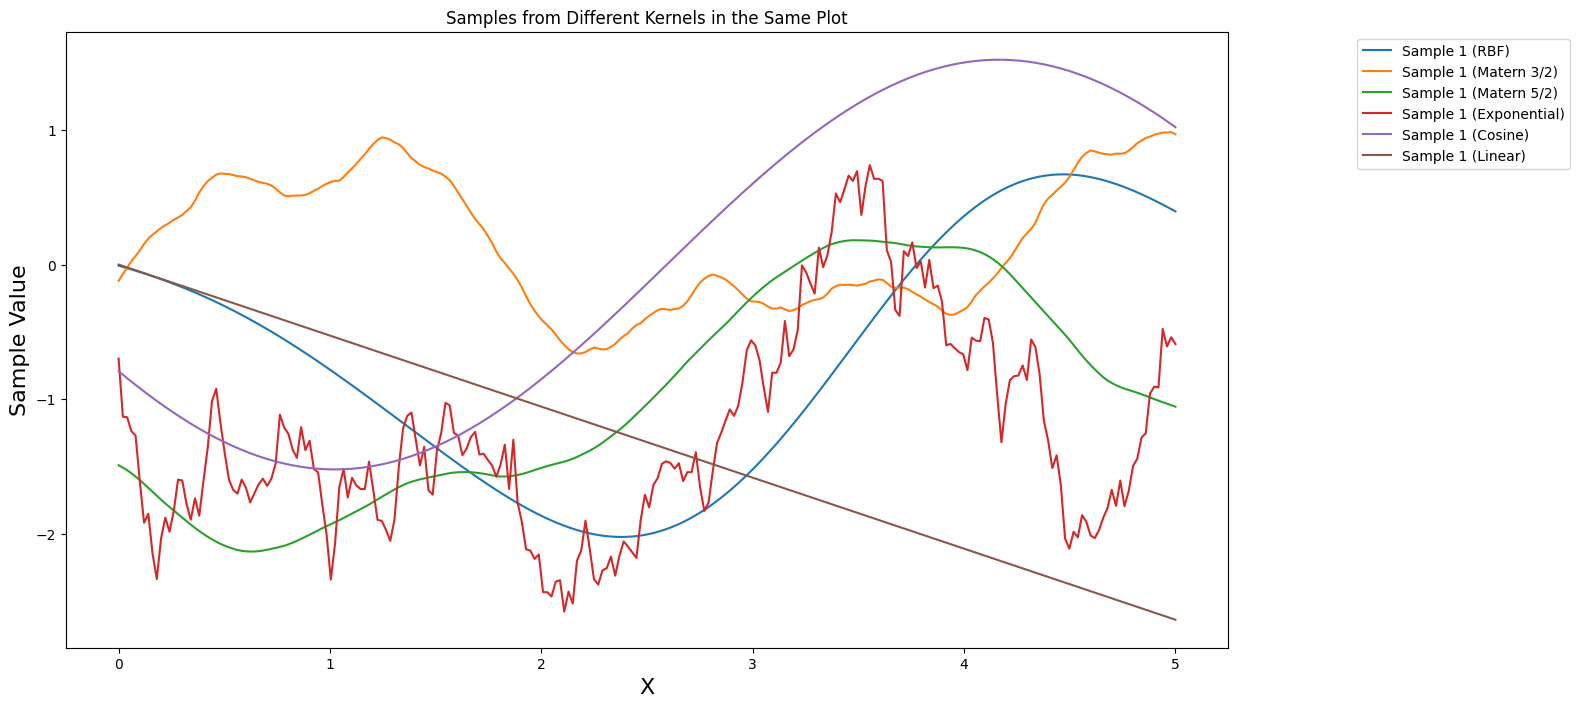

In [10]:
kernels_simple = [
    (GPy.kern.RBF(1), "RBF"),
    (GPy.kern.Matern32(1), "Matern 3/2"),
    (GPy.kern.Matern52(1), "Matern 5/2"),
    (GPy.kern.Exponential(1), "Exponential"),
    (GPy.kern.Cosine(1), "Cosine"),
    (GPy.kern.Linear(1), "Linear"),
]

plot_samples(kernels_simple)

RBF: We can see smooth curves. It is known for its ability to model smooth functions and handle non-linearity. We can see that in the way the line changes gradually

Matern 3/2 and 5/2: It shows smooth variations, not that muchs as RBF. 3/2 is rougher thatn Mathern 5/2.

Exponential: It produces more abrupt changes compared to the previous ones. The lines have sudden, sharp transitions.

Cosine: It shows periodic behavior, resembling sinusoidal waves.

Linear: It generates straight lines, showing purely linear relationship.

To see what happen when the kernels are mixed we try other options like:

RBF + Linear: the result is a smooth curve that tends to drift linearly

RBF * Linear: the overall curve maintains the smooth properties of the RBF but with linear scaling

RBF + Matern 3/2: we get a mix of smooth and rough behavior

RBF * Matern 3/2: The resulting curves are smoother than Matern alone but exhibit some sharper transitions compared to RBF alone

RBF + Cosine: Thw curves are smooth but with periodic waves overlaid



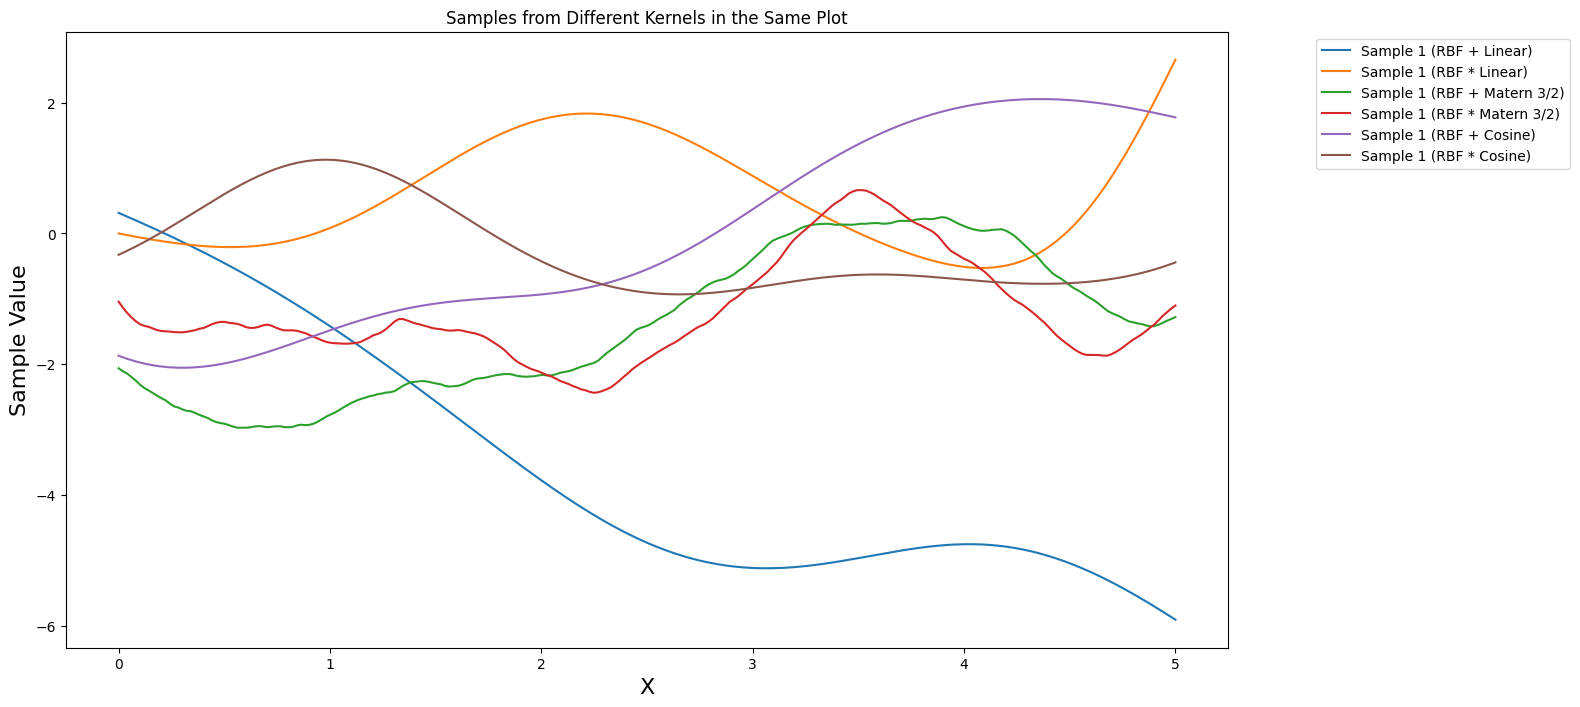

In [11]:
kernels_complex = [
    (GPy.kern.RBF(1) + GPy.kern.Linear(1), "RBF + Linear"),
    (GPy.kern.RBF(1) * GPy.kern.Linear(1), "RBF * Linear"),
    (GPy.kern.RBF(1) + GPy.kern.Matern32(1), "RBF + Matern 3/2"),
    (GPy.kern.RBF(1) * GPy.kern.Matern32(1), "RBF * Matern 3/2"),
    (GPy.kern.RBF(1) + GPy.kern.Cosine(1), "RBF + Cosine"),
    (GPy.kern.RBF(1) * GPy.kern.Cosine(1), "RBF * Cosine"),
]

plot_samples(kernels_complex)

## 1. Best model (no optimization)

In [ ]:
import GPy
import numpy as np
import matplotlib.pyplot as plt

def find_best_kernel(X, Y, kernels_to_try):
    """
    This function tests different kernels and their combinations, optimizes them,
    and returns the one with the best fit based on the maximum log-likelihood.

    Parameters:
        X (np.ndarray): The input data, of shape (n_samples, 1).
        Y (np.ndarray): The output data, of shape (n_samples, 1).
        kernels_to_try (list): List of tuples containing kernels and their names.

    Returns:
        best_kernel (GPy.kern): The kernel with the highest log-likelihood.
        best_model (GPy.models.GPRegression): The GP model using the best kernel.
    """

    best_log_likelihood = -np.inf
    best_kernel = None
    best_model = None
    best_kernel_name = None

    # Loop through each kernel or combination of kernels
    for kernel, kernel_name in kernels_to_try:
        # Create and optimize the GP regression model
        model = GPy.models.GPRegression(X, Y, kernel)
        # model.optimize(messages=False)  # Optimize the model parameters

        # Get the log-likelihood to evaluate model fit
        log_likelihood = model.log_likelihood()
        print(f"Kernel: {kernel_name}, Log-Likelihood: {log_likelihood}")

        # Check if this is the best kernel so far
        if log_likelihood > best_log_likelihood:
            best_log_likelihood = log_likelihood
            best_kernel = kernel
            best_model = model
            best_kernel_name = kernel_name

    print(f"\nBest Kernel: {best_kernel_name} with Log-Likelihood: {best_log_likelihood}")
    return best_kernel, best_model



def plot_best_gp_model(model, X, Y):
  """
  Plots the predictions of the Gaussian Process model with the best kernel,
  including the mean, confidence intervals, and training points.

  Parameters:
      model (GPy.models.GPRegression): The GP model using the best kernel.
      X (np.ndarray): The input training data, of shape (n_samples, 1).
      Y (np.ndarray): The output training data, of shape (n_samples, 1).
  """
  Xnew = np.linspace(X.min(), X.max(), 100)[:, None]
  mean, Cov = model.predict(Xnew, full_cov=True)

  # Calculate the 95% confidence interval
  lower_bound = mean[:, 0] - 1.96 * np.sqrt(np.diag(Cov))
  upper_bound = mean[:, 0] + 1.96 * np.sqrt(np.diag(Cov))

  plt.figure(figsize=(10, 6))
  plt.fill_between(Xnew[:, 0], lower_bound, upper_bound, alpha=0.3, label="95% Confidence Interval")
  plt.plot(Xnew, mean, 'r-', lw=2, label="Mean Prediction")

  plt.plot(X, Y, 'kx', mew=2, label="Training Points")

  plt.xlabel("X")
  plt.ylabel("Y")
  plt.title(f"Gaussian Process Regression with Best Kernel: {model.kern.name}")
  plt.legend()
  plt.show()



In [ ]:
kernels_to_try = [
    (GPy.kern.RBF(1), "RBF"),
    (GPy.kern.Matern32(1), "Matern 3/2"),
    (GPy.kern.Matern52(1), "Matern 5/2"),
    (GPy.kern.Cosine(1), "Cosine"),
    (GPy.kern.Linear(1), "Linear"),
    (GPy.kern.Exponential(1), "Exponential"),
    (GPy.kern.RBF(1) + GPy.kern.Linear(1), "RBF + Linear"),
    (GPy.kern.RBF(1) * GPy.kern.Linear(1), "RBF * Linear"),
    (GPy.kern.RBF(1) + GPy.kern.Matern32(1), "RBF + Matern 3/2"),
    (GPy.kern.RBF(1) * GPy.kern.Matern32(1), "RBF * Matern 3/2"),
    (GPy.kern.Matern32(1) + GPy.kern.Cosine(1), "Matern 3/2 + Cosine"),
    (GPy.kern.Matern52(1) + GPy.kern.Cosine(1), "Matern 5/2 + Cosine"),
    (GPy.kern.Matern52(1) * GPy.kern.Cosine(1), "Matern 5/2 * Cosine"),
    (GPy.kern.Matern32(1) + GPy.kern.Linear(1), "Matern 3/2 + Linear"),
    (GPy.kern.Matern52(1) + GPy.kern.Linear(1), "Matern 5/2 + Linear"),
    (GPy.kern.RBF(1) + GPy.kern.Cosine(1), "RBF + Cosine"),
    (GPy.kern.RBF(1) * GPy.kern.Cosine(1), "RBF * Cosine"),
    (GPy.kern.RBF(1) + GPy.kern.Exponential(1), "RBF + Exponential"),
    (GPy.kern.RBF(1) * GPy.kern.Exponential(1), "RBF * Exponential"),
    (GPy.kern.Matern52(1) + GPy.kern.Exponential(1), "Matern 5/2 + Exponential"),
    (GPy.kern.Exponential(1) + GPy.kern.Cosine(1), "Exponential + Cosine"),
    (GPy.kern.Exponential(1) * GPy.kern.Cosine(1), "Exponential * Cosine"),
    (GPy.kern.Exponential(1) + GPy.kern.Linear(1), "Exponential + Linear"),
    (GPy.kern.Exponential(1) * GPy.kern.Linear(1), "Exponential * Linear"),
    (GPy.kern.RBF(1) + GPy.kern.Matern52(1) + GPy.kern.Cosine(1), "RBF + Matern 5/2 + Cosine"),
    (GPy.kern.RBF(1) + GPy.kern.Linear(1) + GPy.kern.Cosine(1), "RBF + Linear + Cosine"),
    (GPy.kern.RBF(1) * (GPy.kern.Linear(1) + GPy.kern.Cosine(1)), "RBF * (Linear + Cosine)"),
    (GPy.kern.RBF(1) * GPy.kern.Linear(1) * GPy.kern.Cosine(1), "RBF * Linear * Cosine")
]


# Encuentra el mejor kernel basado en la lista actualizada
best_kernel, best_model = find_best_kernel(X, Y, kernels_to_try)


Kernel: RBF, Log-Likelihood: -3232.578922474906
Kernel: Matern 3/2, Log-Likelihood: -3307.794074330792
Kernel: Matern 5/2, Log-Likelihood: -3281.860779520371
Kernel: Cosine, Log-Likelihood: -6908.530084778836
Kernel: Linear, Log-Likelihood: -1803.5750965774982
Kernel: Exponential, Log-Likelihood: -3390.178278506227
Kernel: RBF + Linear, Log-Likelihood: -1440.66681038772
Kernel: RBF * Linear, Log-Likelihood: -11959.41644355347
Kernel: RBF + Matern 3/2, Log-Likelihood: -2571.187800360086
Kernel: RBF * Matern 3/2, Log-Likelihood: -3660.6765711805865
Kernel: Matern 3/2 + Cosine, Log-Likelihood: -3311.858487204762
Kernel: Matern 5/2 + Cosine, Log-Likelihood: -3285.9746741844747
Kernel: Matern 5/2 * Cosine, Log-Likelihood: -3801.9342400623627
Kernel: Matern 3/2 + Linear, Log-Likelihood: -1460.0057564053993
Kernel: Matern 5/2 + Linear, Log-Likelihood: -1454.2618215901095
Kernel: RBF + Cosine, Log-Likelihood: -3236.7694145855185
Kernel: RBF * Cosine, Log-Likelihood: -3719.8720905952746
Kernel:

In [ ]:
kernels_to_try = [
    (GPy.kern.RBF(1) + GPy.kern.Linear(1), "RBF + Linear"),
]

best_kernel, best_model = find_best_kernel(X, Y, kernels_to_try)


Kernel: RBF + Linear, Log-Likelihood: -1440.66681038772

Best Kernel: RBF + Linear with Log-Likelihood: -1440.66681038772


GP_regression.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,1.0,+ve,
sum.linear.variances,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


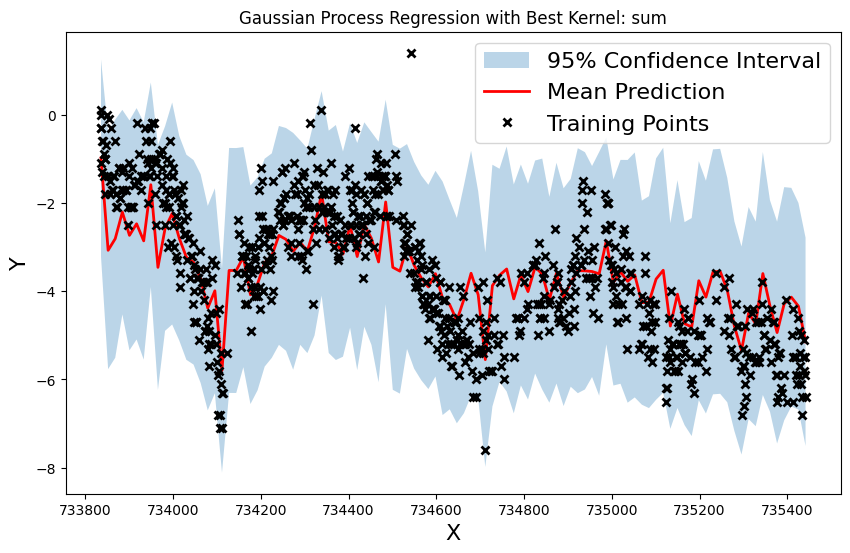

In [ ]:
display(best_model)
plot_best_gp_model(best_model, X, Y)

We initially hypothesized which models might best explain these data based on their distribution. Observing the overall shape, we noted that the data appear to have both smooth variations and some degree of linear trend, along with visible irregularities.

We evaluated various kernels to determine which one provided the best fit for our data, using the log-likelihood as the metric for model fitness. Based on our tests, the RBF + Linear kernel emerged as the best fit, with a log-likelihood value of -1440.67. This suggests that the combination of the Radial Basis Function (RBF) and Linear kernels can effectively capture both the smooth variations and any linear trends in the data.

The combination of RBF and Linear kernels allows the model to account for both smooth nonlinear patterns (through the RBF kernel) and linear trends (through the Linear kernel). This kernel combination was likely chosen by the model because our data exhibits a combination of these characteristics. The relatively high objective value (1440.67) suggests there is substantial variation and noise in the data, which the model is attempting to fit. By including both components, the model achieves a balanced fit that captures these aspects of the data.



## 2. Optimization

In [ ]:
import GPy
import numpy as np

def optimize_multiple_times(X, Y, kernel, num_runs=10):
    """
    Optimizes the Gaussian Process model multiple times with different initializations
    and returns the best model based on log-likelihood.

    Parameters:
        X (np.ndarray): The input data, of shape (n_samples, 1).
        Y (np.ndarray): The output data, of shape (n_samples, 1).
        kernel (GPy.kern): The kernel to use for the GP model.
        num_runs (int): The number of times to run the optimization.

    Returns:
        best_model (GPy.models.GPRegression): The GP model with the highest log-likelihood.
        best_log_likelihood (float): The highest log-likelihood achieved.
    """
    best_log_likelihood = -np.inf
    best_model = None

    # Run multiple optimizations
    for run in range(num_runs):
        # Create a new model and randomize initial parameters
        model = GPy.models.GPRegression(X, Y, kernel.copy())  # Copy kernel to avoid modifying the original
        model.randomize()  # Randomize the starting point of the parameters

        # Optimize the model parameters
        model.optimize(messages=False)  # Suppress optimization messages

        # Get log-likelihood after optimization
        log_likelihood = model.log_likelihood()
        print(f"Run {run + 1}/{num_runs} - Log-Likelihood: {log_likelihood}")

        # Check if this is the best result so far
        if log_likelihood > best_log_likelihood:
            best_log_likelihood = log_likelihood
            best_model = model.copy()  # Store the best model found

    print(f"\nBest Log-Likelihood after {num_runs} runs: {best_log_likelihood}")
    return best_model, best_log_likelihood


Run 1/20 - Log-Likelihood: -937.1226713986262
Run 2/20 - Log-Likelihood: -925.8349307219182
Run 3/20 - Log-Likelihood: -937.9740511940845
Run 4/20 - Log-Likelihood: -925.8349307329299
Run 5/20 - Log-Likelihood: -936.3992661852612
Run 6/20 - Log-Likelihood: -936.3413446490015
Run 7/20 - Log-Likelihood: -986.5243318883126
Run 8/20 - Log-Likelihood: -937.1090836104568
Run 9/20 - Log-Likelihood: -936.6814617200844
Run 10/20 - Log-Likelihood: -925.8349307217668
Run 11/20 - Log-Likelihood: -937.1376672501179
Run 12/20 - Log-Likelihood: -925.834930733545
Run 13/20 - Log-Likelihood: -1583.5535311472515
Run 14/20 - Log-Likelihood: -941.1302202489309
Run 15/20 - Log-Likelihood: -936.2276597316265
Run 16/20 - Log-Likelihood: -941.130220248153
Run 17/20 - Log-Likelihood: -959.7363951916486
Run 18/20 - Log-Likelihood: -976.9053149637647
Run 19/20 - Log-Likelihood: -936.7171978026852
Run 20/20 - Log-Likelihood: -1572.4428690832253

Best Log-Likelihood after 20 runs: -925.8349307217668


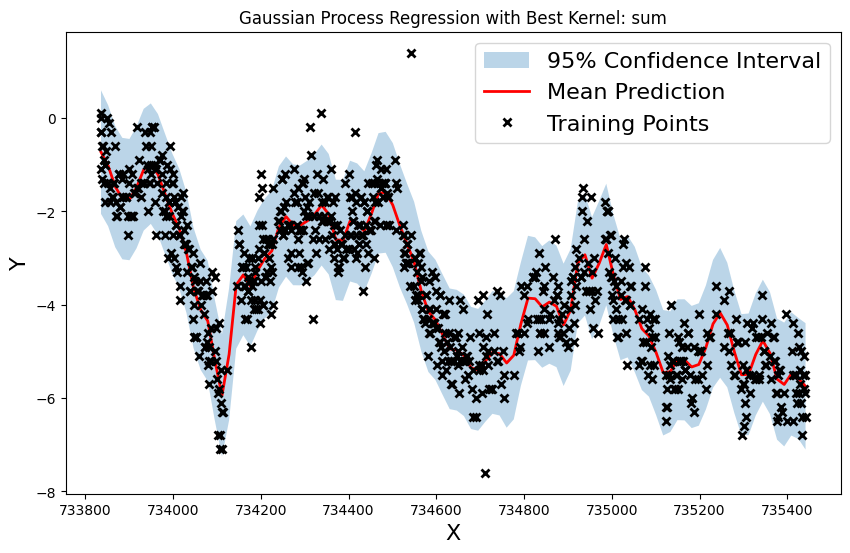

In [ ]:
# Ejecutar la optimización múltiple
best_model_optimized, best_log_likelihood = optimize_multiple_times(X, Y, best_kernel, num_runs=20)

plot_best_gp_model(best_model_optimized, X, Y)

By running the optimization multiple times with different initializations, we managed to achieve a significant improvement in the log-likelihood. Initially, using a single optimization run with the RBF + Linear kernel, the log-likelihood was -1440.67. After re-running the optimization 10 times with different random starting points, we obtained a best log-likelihood of -925.83.


The higher log-likelihood value (less negative) indicates a better fit to the data, as the model has likely escaped from local minima in the optimization landscape by exploring various initial parameter settings.


This improvement suggests that the initial values of the hyperparameters can significantly impact the final result. By running the optimization multiple times, we increased the chance of finding a more optimal set of hyperparameters.


## 3. Prediction

In [ ]:
import matplotlib.pyplot as plt

def do_prediction(Xnew, best_model):
  # Predicción con ruido
  mean_with_noise, cov_with_noise = best_model.predict(Xnew, full_cov=True)

  # Predicción sin ruido
  mean_noiseless, cov_noiseless = best_model.predict_noiseless(Xnew, full_cov=True)

  # Gráfica de predicciones
  plt.figure(figsize=(14, 6))

  # Subplot con ruido
  plt.subplot(1, 2, 1)
  plot_gp(Xnew, mean_with_noise, cov_with_noise, training_points=(X, Y))
  plt.title("Prediction with Noise")

  # Subplot sin ruido
  plt.subplot(1, 2, 2)
  plot_gp(Xnew, mean_noiseless, cov_noiseless, training_points=(X, Y))
  plt.title("Prediction without Noise")

  plt.tight_layout()
  plt.show()


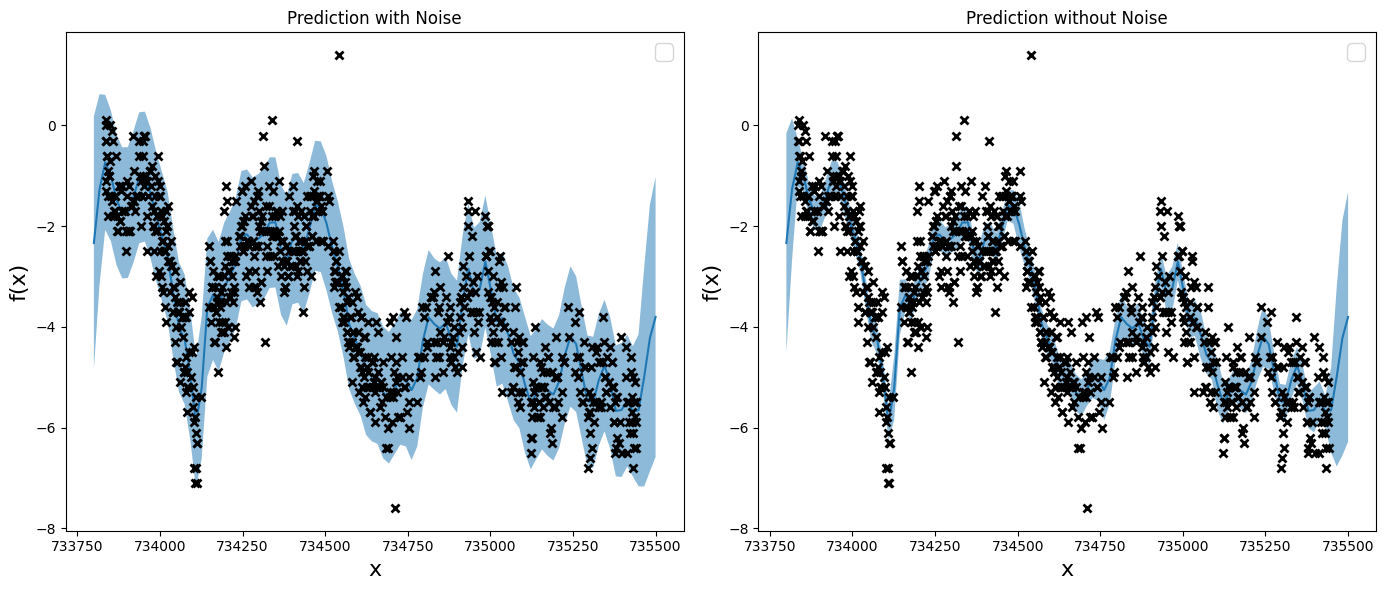

In [ ]:
Xnew = np.linspace(733800, 735500, 100)[:, None]
do_prediction(Xnew, best_model_optimized)

In these two plots, we can see the predictions from our Gaussian Process model with and without observation noise. Here’s how we interpret each result:

**Prediction with Noise**

The blue shaded area represents the uncertainty in our predictions, which appears larger, particularly where data points are sparse.

This uncertainty includes both the model uncertainty and the observation noise, capturing not only the variability described by the kernel but also the randomness inherent in our observed data.

This approach is more relevant when we want to understand the full range of variability, including noise, in our data. It’s suitable if we need our predictions to reflect the total possible uncertainty, especially when observation noise is an important factor.

**Prediction without Noise**

The uncertainty is noticeably smaller here, as indicated by the narrower blue shaded area compared to the left plot.

This plot reflects only the model uncertainty, which means it shows how confident our model is about its predictions based solely on the underlying function, ignoring any noise present in the observations

This approach is ideal when we are interested in the underlying trend or expected behavior of the data, without the influence of random fluctuations.



# Part 2

Size inputs: (85, 1) Size outputs (85, 1)


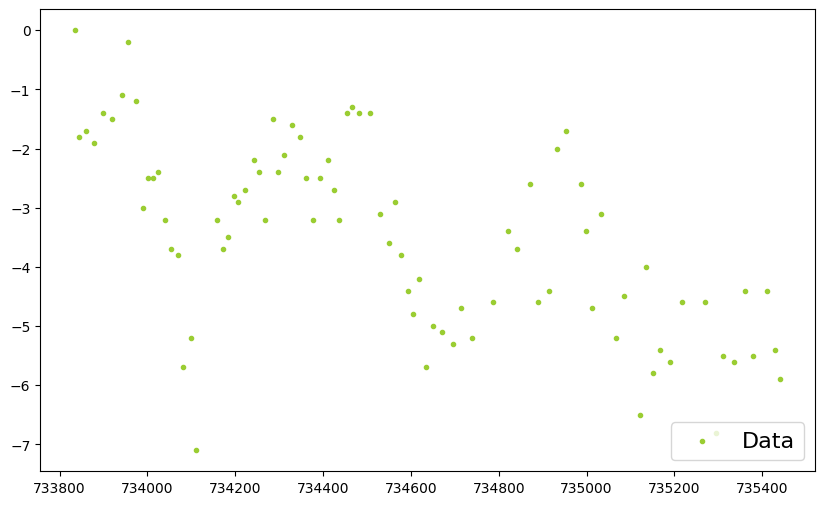

In [ ]:
#@title Load data
# You can also use the weight dataset by uncommenting these lines
data=sp.io.loadmat('weightdata_clean.mat')
X = np.atleast_2d(data['dat'][:,0]).T
Y = np.atleast_2d(data['dat'][:,1]).T

# This can be use to subsample the dataset
subsample = 10
X = X[::subsample,:]
Y = Y[::subsample,:]

# Make sure the data is there
print("Size inputs:", X.shape, "Size outputs",Y.shape)
plt.scatter(X, Y, color='yellowgreen', marker='.',label='Data')
plt.legend(loc='lower right')

## 1. Best model (no optimization)

Kernel: RBF, Log-Likelihood: -418.38352915461996
Kernel: Matern 3/2, Log-Likelihood: -418.3835269954365
Kernel: Matern 5/2, Log-Likelihood: -418.3835290464416
Kernel: Cosine, Log-Likelihood: -676.8191358594167
Kernel: Linear, Log-Likelihood: -200.03720101572327
Kernel: Exponential, Log-Likelihood: -418.38311564842866
Kernel: RBF + Linear, Log-Likelihood: -175.9689863641594
Kernel: RBF * Linear, Log-Likelihood: -1226.207491456855
Kernel: RBF + Matern 3/2, Log-Likelihood: -332.01079608211535
Kernel: RBF * Matern 3/2, Log-Likelihood: -418.38352915461996
Kernel: Matern 3/2 + Cosine, Log-Likelihood: -408.4619220988913
Kernel: Matern 5/2 + Cosine, Log-Likelihood: -408.46192983856855
Kernel: Matern 5/2 * Cosine, Log-Likelihood: -418.3835291997085
Kernel: Matern 3/2 + Linear, Log-Likelihood: -175.9689863641594
Kernel: Matern 5/2 + Linear, Log-Likelihood: -175.9689863641594
Kernel: RBF + Cosine, Log-Likelihood: -408.461930926484
Kernel: RBF * Cosine, Log-Likelihood: -418.38352915461996
Kernel: 

GP_regression.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,1.0,+ve,
sum.linear.variances,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


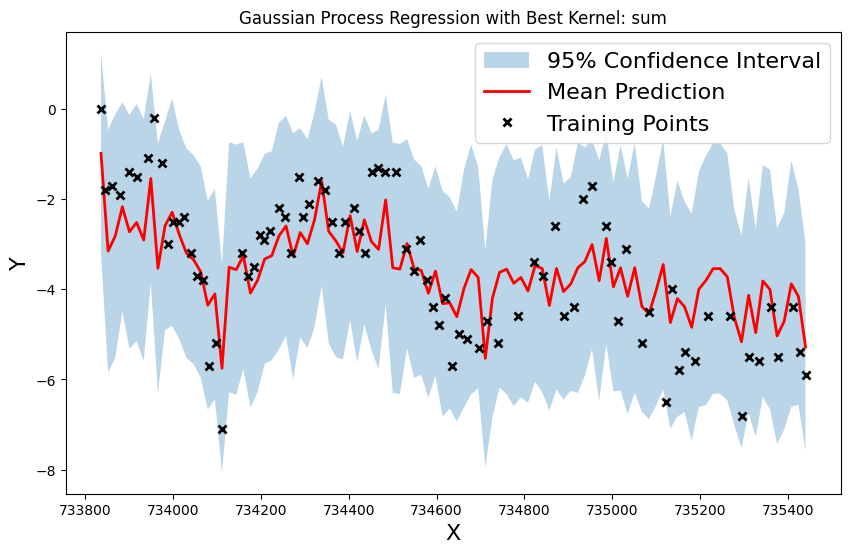

In [ ]:
kernels = [
    (GPy.kern.RBF(1), "RBF"),
    (GPy.kern.Matern32(1), "Matern 3/2"),
    (GPy.kern.Matern52(1), "Matern 5/2"),
    (GPy.kern.Cosine(1), "Cosine"),
    (GPy.kern.Linear(1), "Linear"),
    (GPy.kern.Exponential(1), "Exponential"),
    (GPy.kern.RBF(1) + GPy.kern.Linear(1), "RBF + Linear"),
    (GPy.kern.RBF(1) * GPy.kern.Linear(1), "RBF * Linear"),
    (GPy.kern.RBF(1) + GPy.kern.Matern32(1), "RBF + Matern 3/2"),
    (GPy.kern.RBF(1) * GPy.kern.Matern32(1), "RBF * Matern 3/2"),
    (GPy.kern.Matern32(1) + GPy.kern.Cosine(1), "Matern 3/2 + Cosine"),
    (GPy.kern.Matern52(1) + GPy.kern.Cosine(1), "Matern 5/2 + Cosine"),
    (GPy.kern.Matern52(1) * GPy.kern.Cosine(1), "Matern 5/2 * Cosine"),
    (GPy.kern.Matern32(1) + GPy.kern.Linear(1), "Matern 3/2 + Linear"),
    (GPy.kern.Matern52(1) + GPy.kern.Linear(1), "Matern 5/2 + Linear"),
    (GPy.kern.RBF(1) + GPy.kern.Cosine(1), "RBF + Cosine"),
    (GPy.kern.RBF(1) * GPy.kern.Cosine(1), "RBF * Cosine"),
    (GPy.kern.RBF(1) + GPy.kern.Exponential(1), "RBF + Exponential"),
    (GPy.kern.RBF(1) * GPy.kern.Exponential(1), "RBF * Exponential"),
    (GPy.kern.Matern52(1) + GPy.kern.Exponential(1), "Matern 5/2 + Exponential"),
    (GPy.kern.Exponential(1) + GPy.kern.Cosine(1), "Exponential + Cosine"),
    (GPy.kern.Exponential(1) * GPy.kern.Cosine(1), "Exponential * Cosine"),
    (GPy.kern.Exponential(1) + GPy.kern.Linear(1), "Exponential + Linear"),
    (GPy.kern.Exponential(1) * GPy.kern.Linear(1), "Exponential * Linear"),
    (GPy.kern.RBF(1) + GPy.kern.Matern52(1) + GPy.kern.Cosine(1), "RBF + Matern 5/2 + Cosine"),
    (GPy.kern.RBF(1) + GPy.kern.Linear(1) + GPy.kern.Cosine(1), "RBF + Linear + Cosine"),
    (GPy.kern.RBF(1) * (GPy.kern.Linear(1) + GPy.kern.Cosine(1)), "RBF * (Linear + Cosine)"),
    (GPy.kern.RBF(1) * GPy.kern.Linear(1) * GPy.kern.Cosine(1), "RBF * Linear * Cosine")
]


# Encuentra el mejor kernel basado en la lista actualizada
best_kernel_2, best_model_2 = find_best_kernel(X, Y, kernels)
display(best_model)
plot_best_gp_model(best_model, X, Y)


The kernel combination of RBF + Linear again yielded the best fit, with the highest log-likelihood of -175.97. This indicates that this kernel captures both the non-linearities and the underlying linear trends well, even with a smaller dataset.


In this experiment, with less data, the log-likelihood values generally improved for the better-fitting kernels. This suggests that even with a smaller dataset, Gaussian processes with the right kernel can still capture the main structure of the data effectively.

The worst-performing kernels, however, still produce very low log-likelihoods, indicating they cannot adequately model the reduced data.


## 2. Optimization

Run 1/10 - Log-Likelihood: -162.9840138472911
Run 2/10 - Log-Likelihood: -162.98401384728837
Run 3/10 - Log-Likelihood: -162.9840138474945
Run 4/10 - Log-Likelihood: -162.9840138472849
Run 5/10 - Log-Likelihood: -121.59705538308734
Run 6/10 - Log-Likelihood: -162.98401384739697
Run 7/10 - Log-Likelihood: -162.98401231721647
Run 8/10 - Log-Likelihood: -162.98401384717693
Run 9/10 - Log-Likelihood: -162.9840138472847
Run 10/10 - Log-Likelihood: -162.98401384732495

Best Log-Likelihood after 10 runs: -121.59705538308734


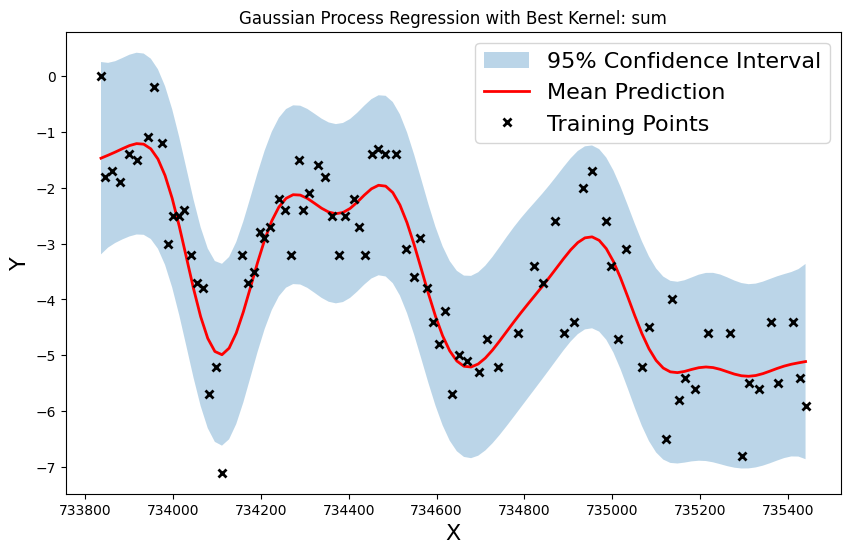

In [ ]:
# Ejecutar la optimización múltiple
best_model_optimized_2, best_log_likelihood_2 = optimize_multiple_times(X, Y, best_kernel_2, num_runs=10)

plot_best_gp_model(best_model_optimized_2, X, Y)

The significant difference in the log-likelihood on Run 5 compared to the other runs suggests that the initial values of the kernel parameters can heavily influence the final result.

## 3. Prediction

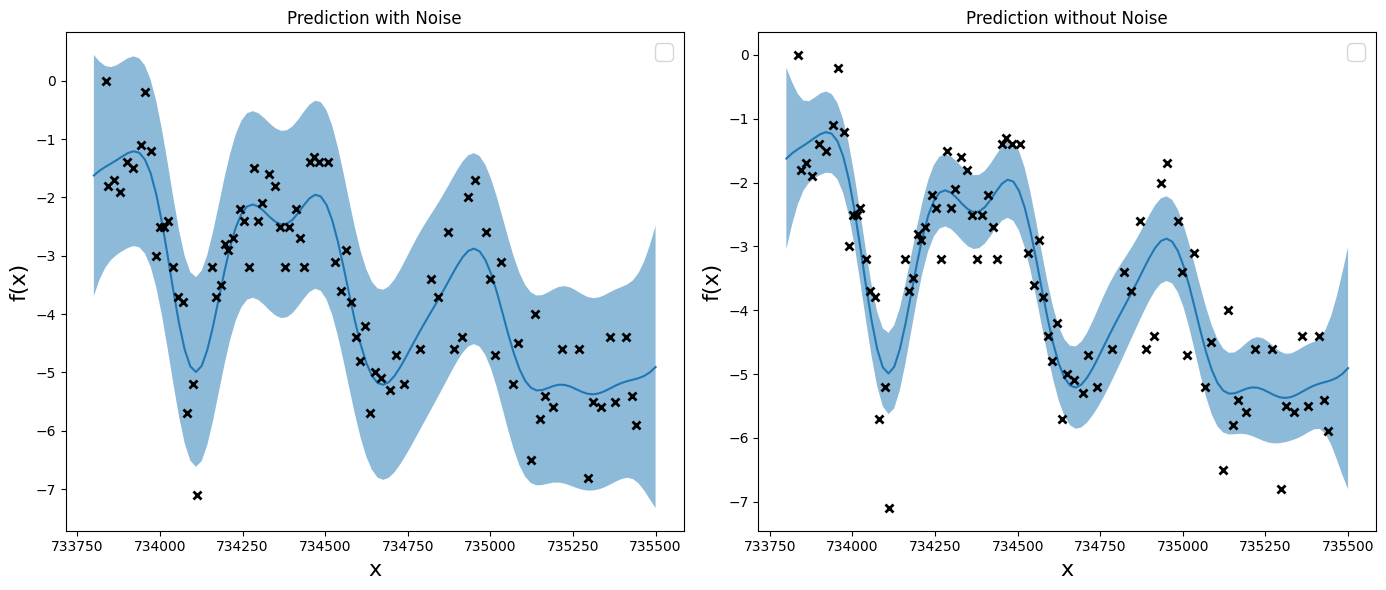

In [ ]:
Xnew = np.linspace(733800, 735500, 100)[:, None]
do_prediction(Xnew, best_model_optimized_2)

Prediction with Noise provides a more conservative estimate of the true function, with wider intervals to reflect uncertainty from both the model and the noisy data.

Prediction without Noise focuses purely on the underlying function, ignoring data noise, which leads to tighter intervals and a smoother prediction.